In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = "D:/chest_xray"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [32]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [33]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_val_test)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_val_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
class_names = train_dataset.classes
class_counts = [len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names]
weights = [max(class_counts) / c for c in class_counts]
class_weights = torch.tensor(weights).float().to(device)

In [35]:
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
model = model.to(device)

In [36]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_acc = val_corrects.double() / len(val_dataset)
        print(f"Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2%}, Val Acc: {val_acc:.2%}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    print(f"\nBest Validation Accuracy: {best_acc:.2%}")
    model.load_state_dict(best_model_wts)

    # Ensure the 'model' directory exists
    os.makedirs("model", exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), "model/pneumonia_efficientnet.pth")
    return model

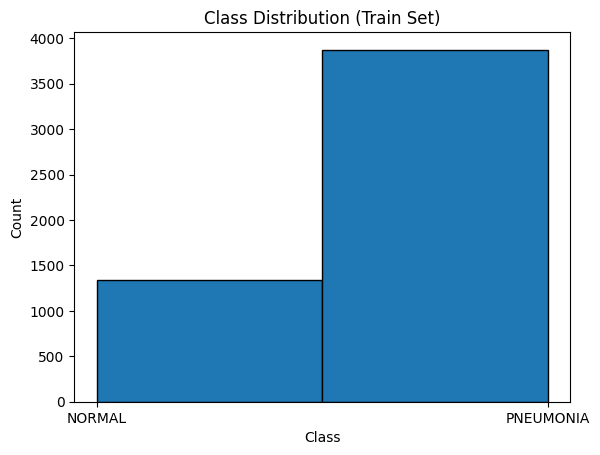

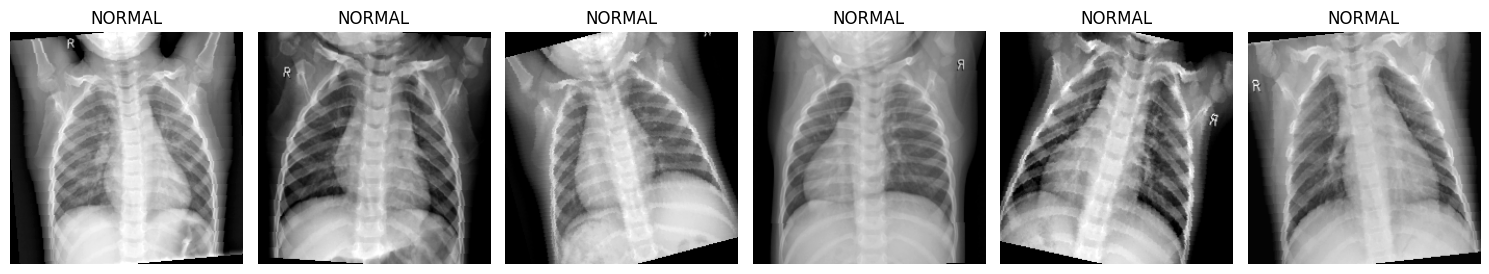

In [ ]:
# Visualize class distribution
labels = train_dataset.targets
plt.hist(labels, bins=2, edgecolor='black')
plt.xticks([0, 1], class_names)
plt.title("Class Distribution (Train Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Show sample images
def show_images(dataset, n=6):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(class_names[label])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_images(train_dataset)

In [49]:
from torchvision import transforms
from PIL import Image

def predict_image(img_path, model, transform):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
    return class_names[pred.item()]

In [45]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10


100%|██████████| 163/163 [01:15<00:00,  2.16it/s]


Loss: 0.0860, Train Acc: 97.47%, Val Acc: 93.75%
Epoch 2/10


100%|██████████| 163/163 [01:13<00:00,  2.23it/s]


Loss: 0.0854, Train Acc: 97.34%, Val Acc: 93.75%
Epoch 3/10


100%|██████████| 163/163 [01:12<00:00,  2.24it/s]


Loss: 0.0763, Train Acc: 97.66%, Val Acc: 93.75%
Epoch 4/10


100%|██████████| 163/163 [01:13<00:00,  2.23it/s]


Loss: 0.0831, Train Acc: 97.37%, Val Acc: 93.75%
Epoch 5/10


100%|██████████| 163/163 [01:13<00:00,  2.23it/s]


Loss: 0.0799, Train Acc: 97.41%, Val Acc: 93.75%
Epoch 6/10


100%|██████████| 163/163 [01:13<00:00,  2.22it/s]


Loss: 0.0749, Train Acc: 97.60%, Val Acc: 93.75%
Epoch 7/10


100%|██████████| 163/163 [01:13<00:00,  2.22it/s]


Loss: 0.0818, Train Acc: 97.12%, Val Acc: 93.75%
Epoch 8/10


100%|██████████| 163/163 [01:13<00:00,  2.22it/s]


Loss: 0.0777, Train Acc: 97.49%, Val Acc: 93.75%
Epoch 9/10


100%|██████████| 163/163 [01:13<00:00,  2.22it/s]


Loss: 0.0776, Train Acc: 97.45%, Val Acc: 93.75%
Epoch 10/10


100%|██████████| 163/163 [01:13<00:00,  2.22it/s]


Loss: 0.0799, Train Acc: 97.47%, Val Acc: 93.75%

Best Validation Accuracy: 93.75%


\nClassification Report:
              precision    recall  f1-score   support

      NORMAL       0.98      0.72      0.83       234
   PNEUMONIA       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.87       624
weighted avg       0.90      0.89      0.88       624



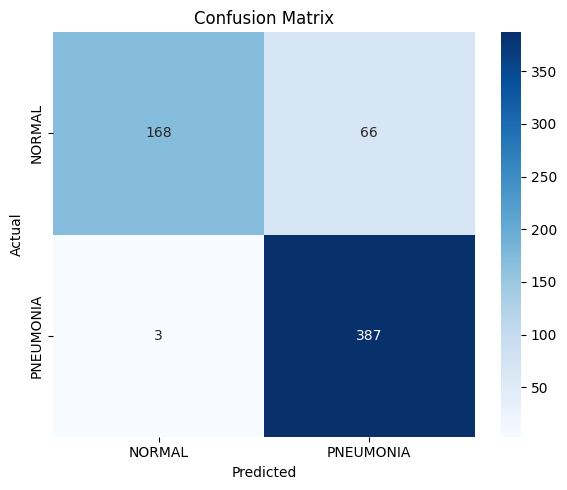

In [47]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.cpu().tolist())

print("\\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
